### Идеи:

1. Мы оцениваем распределение нормальным, считая мат ожидание и дисперсию. Но у нас есть его выборочная плотность. Если мы зафиксируем процент подозрительных случаев, то сможем по плотности найти границу, так чтобы площадь под хвостом была фиксированной. Недостаток: так мы предполагаем, что все задачи списываются одинаково часто. Либо надо уметь как-то получать вероятность списывания для задачи, а это можно сделать по истории выставления черных меток.
2. В связи с 1 наблюдением, правильнее фиксировать вероятность желания списать студентом, а не процент подозрительных пар. У нас есть граф (клика) из n попарно похожих решений, тогда в статистику стоит записывать n событий, а не n^2. Частично клики убираются выкидыванием единиц из плотности распределения.
3. Может, стоит строить плотность по весу максимально похожего решения на решения автора? Тогда у нас будет столько событий, сколько аторов, и мы будем гадать, списал он или не списал.
4. Брать не все пары у 100 авторов, а случайные. И можно взять больше авторов. Это уменьшит взаимозависимость весов.
5. Можно было бы не учитывать авторов не из групп с ревью. Но кажется нет смысла, потому что скрывать списывание без ревью не будут и будут единицы.

### Наблюдения:
1. Если n студентов списали из одного источника, в выборке будет порядка n^2 событий списывания. А для пары студентов это будет одно событие.
2. Распределение весов пар решений - это как вероятность, что кубик выпадет единицей. А Распределение весов максимально похожих решений это как распределение события, что кубик не выпал единицей 10 раз.
3. Распределение весов пар решений почти не меняется со временем. А мат ожидание распределения веса до ближайшего решения свдигается вместе с ростом числа решений, поэтому его надо пересчитывать, чтобы учеть этот фактор.

In [1]:
import json
import scipy.stats as stats
import numpy
import numpy as np 
import statistics
import matplotlib.pyplot as plt
import pandas as pd
from enum import Enum

В файле weights.txt для задач хранятся наборы весов которые использовались антиплагиатом для рассчета стистик распределения весов расстояний между задачами. Для каждой задачи это примерно по 4500 весов. Сравнивались последние посылки 100 последних авторов.

In [2]:
with open("weights.txt", "r", encoding="utf-8") as f:
    content = f.readlines()
loaded = [json.loads(line) for line in content]
tasks = {t["name"]:t for t in loaded}
print("Число задач: " + str(len(tasks.keys())))

Число задач: 59


В файле blackAndWhiteLabels.txt хранятся черные и белые метки. Черная метка - это посылка с комментарием преподавателя о списывании. Белая метка - последняя посылка автора с ненулевым баллом за ревью.

В файле содаржатся данны по посылкам, сделанным с 01.01.2020. Поэтому там много данных по курсу ОП2 и недостаточно по курсу ОП1.

Для каждой указан вес самой похожей на него посылки другого автора. 

In [3]:
# Сразу фильтруем Юля Кленина, потому что он поставил 90% черных меток.
# Если он видит желтую плашку, чтавит черную метку.
badInstructors = set(["6345998a-4250-49f8-9fc4-dcbd24a6c0fd"])

In [4]:
with open("blackAndWhiteLabels.txt", "r", encoding="utf-8") as f:
    content = f.readlines()
loadedLabels = [json.loads(line) for line in content]
tasksWithLabels = dict()
for l in loadedLabels:
    taskId = l["taskId"]
    if l["instructor"] in badInstructors:
        continue
    if not taskId in tasksWithLabels:
        tasksWithLabels[taskId] = dict()
        tasksWithLabels[taskId]["bw"] = [] #blackWeights
        tasksWithLabels[taskId]["ww"] = [] #whiteWeights
    if l["isBlack"]:
        tasksWithLabels[taskId]["bw"].append(l["weight"])
    else:
        tasksWithLabels[taskId]["ww"].append(l["weight"])
print("Число задач: " + str(len(tasksWithLabels.keys())))

Число задач: 58


Посчитаем базовые параметры распределения весов

In [5]:
def GetBetaParameters(mean, sigma):
    alpha = -mean*(sigma**2+mean**2-mean)/(sigma**2)
    beta = (sigma**2+mean**2-mean)*(mean-1)/(sigma**2)
    return (alpha, beta)

Вычислим независиящие от настроек параметры распределения весов между парами задач и расределения весов меток

In [6]:
for name in tasks.keys():
    task = tasks[name]
    task["mean"] = statistics.mean(task["weights"])
    task["sigma"] = statistics.stdev(task["weights"])
    k2, p = stats.normaltest(task["weights"])
    task["isNormal"] = p
    (task["alpha"], task["beta"]) = GetBetaParameters(task["mean"], task["sigma"])

Таблица параметров распределений весов пар задач, осортированная по возрастанию медианы

In [7]:
data = [[name, tasks[name]["mean"], tasks[name]["sigma"], tasks[name]["isNormal"], tasks[name]["alpha"], tasks[name]["beta"], tasks[name]["taskId"]] for name in tasks.keys()]
df = pd.DataFrame(data, columns=["name", "mean", "sigma", "isNormal", "alpha", "beta", "taskId"])
df.sort_values('mean')

,name,mean,sigma,isNormal,alpha,beta,taskId
32,Практика «Бильярд»,0.002056,0.032651,0.000000e+00,0.001900,0.922506,e191b760-98cd-4d54-981a-971f0b4e319d
27,Практика «Рубль -лей -ля»,0.023386,0.075787,0.000000e+00,0.069609,2.906854,f105cca4-2fe6-4842-9894-028c9c6b10b5
43,Практика «Angry Birds»,0.024780,0.110508,0.000000e+00,0.024256,0.954611,9fdf2523-85d0-4180-8ef5-88ab8d6b21ff
53,Практика «Вектор»,0.029235,0.102050,0.000000e+00,0.050435,1.674721,e6b85bbf-1dbf-4099-84db-906579169b8d
21,Практика «Проценты»,0.037653,0.079674,0.000000e+00,0.177276,4.530892,6cc09002-9973-4328-a31b-c7343f8c6b5d
6,Практика «Пустой лабиринт»,0.039773,0.126510,0.000000e+00,0.055134,1.331089,6dd79ed2-2d6e-487f-88dc-7414a15600fa
29,Практика «Readonly Vector»,0.041389,0.151024,0.000000e+00,0.030608,0.708913,74ecaabe-c692-487e-8ff7-b1c38ae497b2
31,Практика «Расстояние до отрезка»,0.050099,0.097115,0.000000e+00,0.202690,3.843136,da80ee9b-a2f1-4648-87c2-1a8170561bf0
49,Практика «Документация»,0.050344,0.089680,0.000000e+00,0.248929,4.695659,d6e4df45-0a2f-47c9-ad6d-19cc69e9c549
47,Практика «Два прямоугольника»,0.050588,0.094496,0.000000e+00,0.221505,4.157124,1da7338b-910e-45af-9648-dcf615bf2f1c


Заведем функции, вычисляюще границы по параметрам распределения и коэффициентам из настроек

In [8]:
class Distribution(Enum):
    Normal = 1
    Beta = 2

In [9]:
antiplagOptions = { # Значения из кода антиплагиата
    "distribution": Distribution.Normal,
    "faintSuspicionCoefficient": 4,
    "strongSuspicionCoefficient": 7,
    "minFaintSuspicionLevel": 0.25,
    "minStrongSuspicionLevel": 0.4,
    "maxFaintSuspicionLevel": 0.90,
    "maxStrongSuspicionLevel": 0.98
}

Функция, ограничивающая границы сверху

In [10]:
def GetSuspicionLevelWithThreshold(value, minValue, maxValue):
    if value < minValue:
        return minValue
    if value > maxValue:
        return maxValue
    return value

In [11]:
def GetSuspicionLevels(mean, sigma, options):
    o = options
    if options["distribution"] == Distribution.Normal:
        faintSuspicion = GetSuspicionLevelWithThreshold(mean + o["faintSuspicionCoefficient"] * sigma,
                                                    o["minFaintSuspicionLevel"], o["maxFaintSuspicionLevel"])
        strongSuspicion = GetSuspicionLevelWithThreshold(mean + o["strongSuspicionCoefficient"] * sigma,
                                                     o["minStrongSuspicionLevel"], o["maxStrongSuspicionLevel"])
        return (faintSuspicion, strongSuspicion)
    if options["distribution"] == Distribution.Beta:
        (alpha, beta) = GetBetaParameters(mean, sigma)
        faintSuspicionWithoutThreshold = stats.beta.ppf(stats.norm.cdf(o["faintSuspicionCoefficient"]), alpha, beta)
        strongSuspicionWithoutThreshold = stats.beta.ppf(stats.norm.cdf(o["strongSuspicionCoefficient"]), alpha, beta)
        faintSuspicion = GetSuspicionLevelWithThreshold(faintSuspicionWithoutThreshold,
                                                        o["minFaintSuspicionLevel"], o["maxFaintSuspicionLevel"])
        strongSuspicion = GetSuspicionLevelWithThreshold(strongSuspicionWithoutThreshold,
                                                        o["minStrongSuspicionLevel"], o["maxStrongSuspicionLevel"])
        return (faintSuspicion, strongSuspicion)
    return ()

In [12]:
for name in tasks.keys():
    task = tasks[name]
    taskId = task["taskId"]
    if taskId in tasksWithLabels:
        labels = task["labels"] = dict()
        (faintSuspicion, strongSuspicion) = GetSuspicionLevels(task["mean"], task["sigma"], antiplagOptions)
        labels["bw"] = list(filter(lambda e:e >= faintSuspicion, tasksWithLabels[taskId]["bw"]))
        labels["ww"] = tasksWithLabels[taskId]["ww"]
        labels["all"] = labels["bw"].copy()
        labels["all"].extend(labels["ww"])
        labels["mean"] = mean = statistics.mean(list(filter(lambda e:e<0.99, labels["all"])))
        labels["sigma"] = sigma = statistics.stdev(list(filter(lambda e:e<0.99,labels["all"])))
        k2, p = stats.normaltest(labels["all"])
        labels["isNormal"] = p
        (labels["alpha"], labels["beta"]) = GetBetaParameters(labels["mean"], labels["sigma"])
    else:
        task["labels"] = None

Нарисуем гистограмму экспериментальную плотность распределения весов между задачами.

И наложим на него графики нормального (оранжевый) и бета (зеленый) распределений.

В фоне зеленым и черным покажем количества белых и черных меток, если меток достаточно много.

Желтым и красным цветом покажем границы появления желтой и красной плашки в текущем антиплаиате.

In [13]:
def currentAntiplagPlot(ax, task):
    weights = task["weights"]
    mean = task["mean"]
    sigma = task["sigma"]
    (faintSuspicion, strongSuspicion) = GetSuspicionLevels(mean, sigma, antiplagOptions)
    bins = 50
    colors = ["blue", "yellow", "red"]
    divisions = [
        range(0, int(faintSuspicion*bins)),
        range(int(faintSuspicion*bins), int(strongSuspicion*bins)),
        range(int(strongSuspicion*bins), bins)
    ]
    if task["labels"] is not None and len(task["labels"]["ww"]) > 10:
        ax.hist(task["labels"]["ww"], 200, color = "lightgreen")
        ax.hist(task["labels"]["bw"], 200, color = "black")
    n, bins, patches = ax.hist(weights, 50, density = True)
    for d in divisions:
        for i in d:
            patches[i].set_color(colors[divisions.index(d)])
            patches[i].set_edgecolor("black")
    ax.set_title(task["name"])
    ax.set_ylim([0, 5])
    ax.set_xlim([0, 1])
    x = np.linspace(0, 1, 100)
    ax.plot(x, stats.norm.pdf(x, mean, sigma))
    ax.plot(x, stats.beta.pdf(x, task["alpha"], task["beta"]))

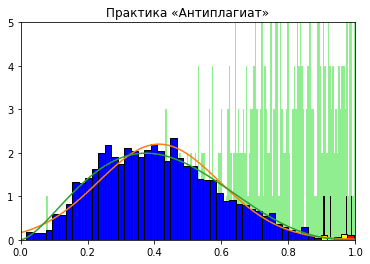

In [14]:
fig, ax = plt.subplots(1)
currentAntiplagPlot(ax, tasks['Практика «Антиплагиат»'])

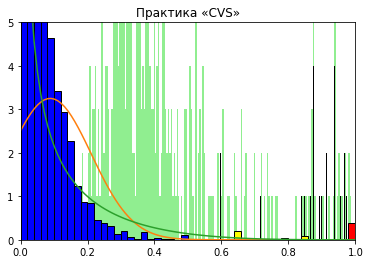

In [15]:
fig, ax = plt.subplots(1)
currentAntiplagPlot(ax, tasks['Практика «CVS»'])

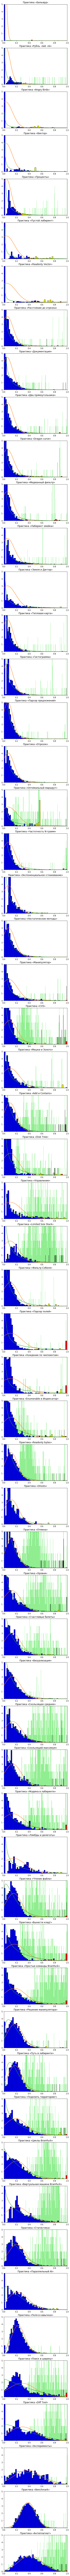

In [16]:
fig, axs = plt.subplots(len(tasks), figsize = (6, 250))
i = 0;
sortedTasks = list(tasks.values())
sortedTasks.sort(key=lambda x:x["mean"])
for task in sortedTasks:
    currentAntiplagPlot(axs[i], task)
    i+=1

Вычислим, где должны находиться оптимальные границы

##### Отфильтруем только задания, для которых есть бльше 100 меток

In [187]:
filteredLabelsTasks = []
for task in tasks.values():
    if task["labels"] is not None and len(task["labels"]["all"]) > 100 and len(task["labels"]["bw"]) > 10:
        filteredLabelsTasks.append(task)
filteredLabelsTasks.sort(key=lambda t: t["mean"])

In [188]:
data = [[task["name"],
         len(task["labels"]["bw"])/len(task["labels"]["all"]),
         len(task["labels"]["all"]),
         task["taskId"]
        ] for task in filteredLabelsTasks]
df = pd.DataFrame(data, columns=["name",
                                 "plagiat",
                                 "labelsCount",
                                 "taskId"
                                 ])
df.sort_values("plagiat", ascending=False)

,name,plagiat,labelsCount,taskId
1,Практика «Add и Contains»,0.094937,316,afe12078-2dad-44f0-912f-3bab93762952
16,Практика «Статистика»,0.090000,400,5181e761-87e7-4914-a963-6fe78c5c7fbc
0,Практика «CVS»,0.077889,398,1d5457ac-46f1-43af-b902-abfba0a0c280
2,Практика «Disk Tree»,0.074766,214,7679fb89-2a2b-4aba-9832-58a54f20e3ff
8,Практика «Счастливые билеты»,0.066148,257,8045998a-36c9-436d-8b10-fa1cd5d94388
19,Практика «Антиплагиат»,0.063158,380,56409c8e-d038-45f7-8e37-e98c027b7930
12,Практика «Чтение файла»,0.060386,414,0217848c-5227-415f-a9d2-4c7e41111601
18,Практика «Diff Tool»,0.056886,334,d71f996c-3bb0-4909-8c03-47322c4f0498
15,Практика «Поделить территорию!»,0.055072,345,c5ca2435-13ea-4b96-ac51-c673f06c4c34
6,Практика «Отмена»,0.053506,542,ab3d7575-9bb1-4a4f-8d07-c1a7c2646f40


In [189]:
# Хотим терять не больше % плагиата
yellowBlackLabelsPercentile = 10
redBlackLabelsPercentile = 40
# Хотим показывать плашку, если плагиат в % случаев в этом окне
yellowBlackPercentInWindow = 0.1
yellowWindowSize = 1/10
redBlackPercentInWindow = 0.3
redWindowSize = 1/20
# Поскольку оба этих критерия могут противоречить, найдем границы по каждому из критериев,
# а потом сложим границы. Первую возьмем с коэффициентом
blackLabelsPercentileCoeff = 0.2
# вторую с коэффициентом 1 - blackLabelsPercentileCoeff

In [190]:
def GetLeftBinWithBlackPercentInWindow(bw, ww, percent, window): # 50% задавать как 0.5
    step = 0.01
    for i in numpy.arange(1.0, window, -step):
        blackInWindow = list(filter(lambda e:e > i - window and e <= i, bw))
        whiteInWindow = list(filter(lambda e:e > i - window and e <= i, ww))
        if len(blackInWindow) + len(whiteInWindow) < 5:
            continue
        result = len(blackInWindow)/(len(blackInWindow) + len(whiteInWindow))
        if result < percent:
            return i - window / 2 + step
    return 0

In [191]:
for task in filteredLabelsTasks:
    labels = task["labels"]
    labels["blackLabelsFaintPercentile"] = np.percentile(labels["bw"], yellowBlackLabelsPercentile)
    labels["blackLabelsStrongPercentile"] = np.percentile(labels["bw"], redBlackLabelsPercentile)
    labels["yellowBlackPercentInWindow"] = GetLeftBinWithBlackPercentInWindow(labels["bw"], labels["ww"], yellowBlackPercentInWindow, yellowWindowSize)
    labels["redBlackPercentInWindow"] = GetLeftBinWithBlackPercentInWindow(labels["bw"], labels["ww"], redBlackPercentInWindow, redWindowSize)
    #labels["yellowBorder"] = labels["blackLabelsFaintPercentile"]
    #labels["redBorder"] = labels["blackLabelsStrongPercentile"]
    labels["yellowBorder"] = (1 - blackLabelsPercentileCoeff) * labels["yellowBlackPercentInWindow"] \
        + blackLabelsPercentileCoeff * labels["blackLabelsFaintPercentile"]
    labels["redBorder"] = (1 - blackLabelsPercentileCoeff) * labels["redBlackPercentInWindow"] \
        + blackLabelsPercentileCoeff * labels["blackLabelsStrongPercentile"]

In [192]:
data = [[task["name"],
         task["mean"],
         GetSuspicionLevels(task["mean"], task["sigma"], antiplagOptions)[0],
         task["labels"]["blackLabelsFaintPercentile"],
         task["labels"]["yellowBlackPercentInWindow"],
         task["labels"]["yellowBorder"],
         GetSuspicionLevels(task["mean"], task["sigma"], antiplagOptions)[1],
         task["labels"]["blackLabelsStrongPercentile"],
         task["labels"]["redBlackPercentInWindow"],
         task["labels"]["redBorder"],
        ] for task in filteredLabelsTasks]
df = pd.DataFrame(data, columns=["name",
                                 "mean",
                                 "faintSuspicion",
                                 "blackLabelsFaint Percentile",
                                 "yellowBlackPercent InWindow",
                                 "yellow Border",
                                 "strongSuspicion",
                                 "blackLabelsStrong Percentile",
                                 "redBlackPercent InWindow",
                                 "red Border"])
df

,name,mean,faintSuspicion,blackLabelsFaint Percentile,yellowBlackPercent InWindow,yellow Border,strongSuspicion,blackLabelsStrong Percentile,redBlackPercent InWindow,red Border
0,Практика «CVS»,0.088606,0.579432,0.790196,0.75,0.758039,0.947552,0.873817,0.975,0.954763
1,Практика «Add и Contains»,0.096965,0.502668,0.729312,0.77,0.761862,0.806946,0.961307,0.815,0.844261
2,Практика «Disk Tree»,0.097118,0.629029,0.714974,0.66,0.670995,0.980000,0.797583,0.985,0.947517
3,Практика «Управление»,0.098910,0.796917,0.921260,0.95,0.944252,0.980000,1.000000,0.985,0.988000
4,Практика «Limited Size Stack»,0.098947,0.640294,0.701258,0.95,0.900252,0.980000,0.805195,0.975,0.941039
5,Практика «Readonly bytes»,0.114093,0.530432,0.731214,0.73,0.730243,0.842685,0.886179,0.985,0.965236
6,Практика «Отмена»,0.121332,0.503427,0.614788,0.74,0.714958,0.789999,0.823432,0.875,0.864686
7,Практика «Уровни»,0.128191,0.682220,0.735715,0.95,0.907143,0.980000,0.963167,0.975,0.972633
8,Практика «Счастливые билеты»,0.131904,0.653250,0.833338,0.83,0.830668,0.980000,0.954315,0.985,0.978863
9,Практика «Скользящее среднее»,0.140246,0.695226,0.789066,0.96,0.925813,0.980000,0.907258,0.985,0.969452


Подбор коэффициента перед сигма, чтобы приблизиться к оптимальным границам.

Для этого мы считаем с какой вероятностью значение отклонится от мат ожидания до границы. По этой вероятности считаем коэффициент перед сигма дял каждой задачи. И берем медиану этих коэффициентов.

In [193]:
afs = []
ass = []
abfs = []
abss = []
for task in filteredLabelsTasks:
    mu = task["mean"]
    sigma = task["sigma"]
    fs = stats.norm.cdf(task["labels"]["yellowBorder"], mu, sigma)
    fs = stats.norm.ppf(fs)
    afs.append(fs)
    ss = stats.norm.cdf(task["labels"]["redBorder"], mu, sigma)
    ss = stats.norm.ppf(ss)
    ass.append(ss)
    alpha = task["alpha"]
    beta = task["beta"]
    bfs = stats.beta.cdf(task["labels"]["yellowBorder"], alpha, beta)
    bfs = stats.norm.ppf(bfs)
    abfs.append(bfs)
    bss = stats.beta.cdf(task["labels"]["redBorder"], alpha, beta)
    bss = stats.norm.ppf(bss)
    abss.append(bss)
    #print(str(round(fs,1)) + " " + str(round(ss,1)) + " " + str(round(bfs,1)) + " " + str(round(bss,1)))

meanafs = statistics.median(afs)
meanass = statistics.median(ass)
meanabfs = statistics.median(abfs)
meanabss = statistics.median(abss)
print("Сигмы границ для нормального распределения")
print(str(round(meanafs,2)) + " " + str(round(meanass,2)))
print("Сигмы границ для бета распределения")
print(str(round(meanabfs,2)) + " " + str(round(meanabss,2)))

Сигмы границ для нормального распределения
5.1 6.04
Сигмы границ для бета распределения
3.7 4.65


In [194]:
normalOptions = {
    "distribution": Distribution.Normal,
    "faintSuspicionCoefficient": meanafs,
    "strongSuspicionCoefficient": meanass,
    "minFaintSuspicionLevel": 0.25,
    "minStrongSuspicionLevel": 0.4,
    "maxFaintSuspicionLevel": 0.90,
    "maxStrongSuspicionLevel": 0.98
}

In [195]:
betaOptions = {
    "distribution": Distribution.Beta,
    "faintSuspicionCoefficient": meanabfs,
    "strongSuspicionCoefficient": meanabss,
    "minFaintSuspicionLevel": 0.25,
    "minStrongSuspicionLevel": 0.4,
    "maxFaintSuspicionLevel": 0.90,
    "maxStrongSuspicionLevel": 0.98
}

In [196]:
afsdiff = []
abfsdiff = []
for i in range(0, len(filteredLabelsTasks)):
    task = filteredLabelsTasks[i]
    (normalFaintSuspicion, normalStrongSuspicion) = GetSuspicionLevels(task["mean"], task["sigma"], normalOptions)
    (betaFaintSuspicion, betaStrongSuspicion) = GetSuspicionLevels(task["mean"], task["sigma"], betaOptions)
    afsdiff.append(normalFaintSuspicion - task["labels"]["yellowBorder"])
    abfsdiff.append(betaFaintSuspicion - task["labels"]["yellowBorder"])
print("Максимальное отклонение (norm): " + str(round(max(afsdiff),2)))
print("Максимальное отклонение (beta): " + str(round(max(abfsdiff),2)))
print("Минимальное отклонение (norm): " + str(round(min(afsdiff),2)))
print("Минимальное отклонение (beta): " + str(round(min(abfsdiff),2)))
print("Стандартное оклонение (norm): " + str(round(statistics.stdev(afsdiff),2)))
print("Стандартное оклонение (beta): " + str(round(statistics.stdev(abfsdiff),2)))
print("Медиана (norm): " + str(round(statistics.mean(afsdiff),2)))
print("Медиана (beta): " + str(round(statistics.mean(abfsdiff),4)))

for i in range(0, len(filteredLabelsTasks)):
    task = filteredLabelsTasks[i]
    (normalFaintSuspicion, normalStrongSuspicion) = GetSuspicionLevels(task["mean"], task["sigma"], normalOptions)
    (betaFaintSuspicion, betaStrongSuspicion) = GetSuspicionLevels(task["mean"], task["sigma"], betaOptions)
    afsdiff.append(normalStrongSuspicion - task["labels"]["redBorder"])
    abfsdiff.append(betaStrongSuspicion - task["labels"]["redBorder"])
#print(statistics.stdev(afsdiff))
#print(statistics.stdev(abfsdiff))

Максимальное отклонение (norm): 0.1
Максимальное отклонение (beta): 0.21
Минимальное отклонение (norm): -0.15
Минимальное отклонение (beta): -0.08
Стандартное оклонение (norm): 0.06
Стандартное оклонение (beta): 0.06
Медиана (norm): -0.03
Медиана (beta): -0.0066


In [197]:
def labelshistogram(ax, task):
    labels = task["labels"]
    (normalFaintSuspicion, normalStrongSuspicion) = GetSuspicionLevels(task["mean"], task["sigma"], antiplagOptions)
    (betaFaintSuspicion, betaStrongSuspicion) = GetSuspicionLevels(task["mean"], task["sigma"], betaOptions)
    bins = 50
    colors = ["blue", "yellow", "red"]
    divisions = [
        range(0, int(normalFaintSuspicion*bins)),
        range(int(normalFaintSuspicion*bins), int(normalStrongSuspicion*bins)),
        range(int(normalStrongSuspicion*bins), bins)
    ]
    betaDivisions = [
        range(0, int(betaFaintSuspicion*bins)),
        range(int(betaFaintSuspicion*bins), int(betaStrongSuspicion*bins)),
        range(int(betaStrongSuspicion*bins), bins)
    ]
    lweights = labels["all"]
    lweightsWith0 = lweights.copy()
    lweightsWith0.append(0)
    lweightsWith0.append(1)
    n, bins, patches = ax[0].hist(lweightsWith0, 50)
    for d in divisions:
        for i in d:
            patches[i].set_color(colors[divisions.index(d)])
            patches[i].set_edgecolor("black")
    n, bins, patches = ax[1].hist(lweightsWith0, 50)
    for d in betaDivisions:
        for i in d:
            patches[i].set_color(colors[betaDivisions.index(d)])
            patches[i].set_edgecolor("black")
    ax[0].set_title(task["name"] + " normal")
    ax[0].set_ylim([0, 50])
    ax[0].set_xlim([0, 1])
    ax[1].set_title(task["name"] + " beta")
    ax[1].set_ylim([0, 50])
    ax[1].set_xlim([0, 1])
    bwWith0 = task["labels"]["bw"].copy()
    bwWith0.append(0)
    bwWith0.append(1)
    ax[0].hist(bwWith0, bins, color = "black")
    ax[1].hist(bwWith0, bins, color = "black")

In [198]:
data = [[task["name"],
         task["mean"],
         GetSuspicionLevels(task["mean"], task["sigma"], normalOptions)[0],
         GetSuspicionLevels(task["mean"], task["sigma"], betaOptions)[0],
         task["labels"]["yellowBorder"],
         GetSuspicionLevels(task["mean"], task["sigma"], normalOptions)[1],
         GetSuspicionLevels(task["mean"], task["sigma"], betaOptions)[1],
         task["labels"]["redBorder"],
        ] for task in filteredLabelsTasks]
df = pd.DataFrame(data, columns=["name",
                                 "mean",
                                 "normalFaintSuspicion",
                                 "betaFaintSuspicion",
                                 "yellowBorder",
                                 "normalStrongSuspicion",
                                 "betaStrongSuspicion",
                                 "redBorder"])
df

,name,mean,normalFaintSuspicion,betaFaintSuspicion,yellowBorder,normalStrongSuspicion,betaStrongSuspicion,redBorder
0,Практика «CVS»,0.088606,0.714750,0.848020,0.758039,0.829337,0.946423,0.954763
1,Практика «Add и Contains»,0.096965,0.614518,0.711739,0.761862,0.709233,0.843883,0.844261
2,Практика «Disk Tree»,0.097118,0.775673,0.878285,0.670995,0.899852,0.961948,0.947517
3,Практика «Управление»,0.098910,0.900000,0.900000,0.944252,0.980000,0.980000,0.988000
4,Практика «Limited Size Stack»,0.098947,0.789539,0.884817,0.900252,0.915921,0.965067,0.941039
5,Практика «Readonly bytes»,0.114093,0.645213,0.704758,0.730243,0.742411,0.832709,0.965236
6,Практика «Отмена»,0.121332,0.608768,0.647863,0.714958,0.697971,0.775979,0.864686
7,Практика «Уровни»,0.128191,0.834961,0.858327,0.907143,0.964304,0.947411,0.972633
8,Практика «Счастливые билеты»,0.131904,0.796981,0.820403,0.830668,0.918694,0.922308,0.978863
9,Практика «Скользящее среднее»,0.140246,0.848230,0.847926,0.925813,0.977795,0.939584,0.969452


На графиках показаны результаты обучения для обоих распределений

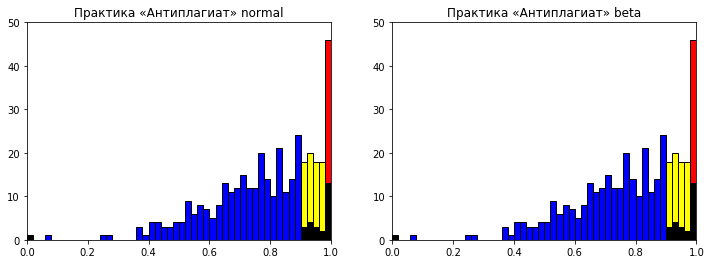

In [199]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
labelshistogram(ax, tasks['Практика «Антиплагиат»'])

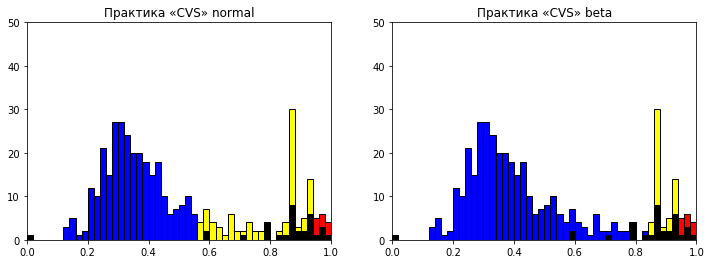

In [200]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
labelshistogram(ax, tasks['Практика «CVS»'])

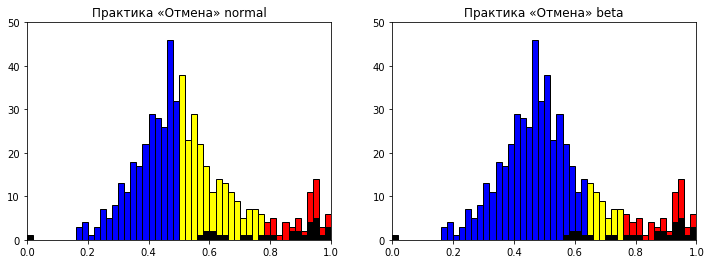

In [201]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
labelshistogram(ax, tasks['Практика «Отмена»'])

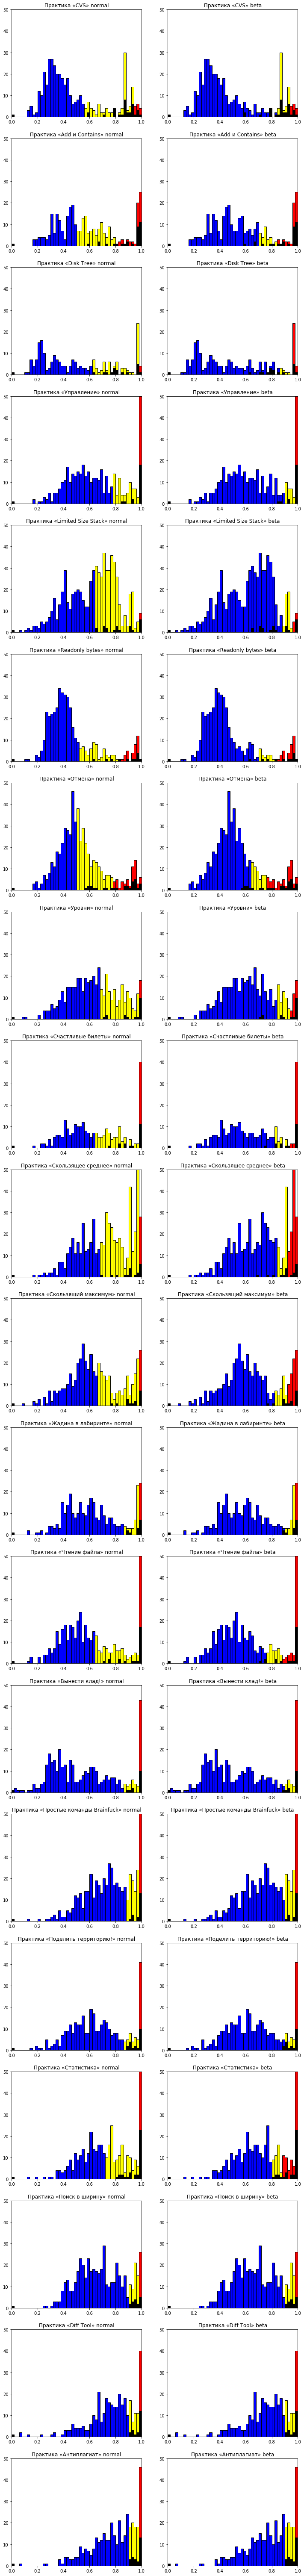

In [212]:
fig, axs = plt.subplots(len(filteredLabelsTasks), 2, figsize = (12, 110))
i = 0;
for task in filteredLabelsTasks:
    labelshistogram(axs[i], task)
    i+=1

### Сравнение с текущим состоянием

Сравниваем процент белых меток при желтой и красной плашке.

Сравниваем процент черных меток при желтой и красной плашке.

In [213]:
def GetPercentLabelsInZones(task, faintSuspicion, strongSuspicion):
    labels = task["labels"]
    ww = labels["ww"]
    bw = labels["bw"]
    result = dict()
    result["whiteInYellowAndRed"] = len(list(filter(lambda e:e >= faintSuspicion, ww)))/len(ww)
    result["whiteInRed"] = len(list(filter(lambda e:e >= strongSuspicion, ww)))/len(ww)
    result["blackInYellowAndRed"] = len(list(filter(lambda e:e >= faintSuspicion, bw)))/len(bw)
    result["blackInRed"] = len(list(filter(lambda e:e >= strongSuspicion, bw)))/len(bw)
    return result

In [214]:
def GetEmptyPercentLabelsInZonesDict():
    return {"whiteInYellowAndRed": 0, "whiteInRed": 0, "blackInYellowAndRed":0, "blackInRed":0}
def AddPercentLabelsInZones(storage, values):
    storage["whiteInYellowAndRed"] += values["whiteInYellowAndRed"]
    storage["whiteInRed"] += values["whiteInRed"]
    storage["blackInYellowAndRed"] += values["blackInYellowAndRed"]
    storage["blackInRed"] += values["blackInRed"]

allForAntiplag = GetEmptyPercentLabelsInZonesDict()
allForNormal = GetEmptyPercentLabelsInZonesDict()
allForBeta = GetEmptyPercentLabelsInZonesDict()
allForOptimum = GetEmptyPercentLabelsInZonesDict()
count = 0
for task in filteredLabelsTasks:
    (faintSuspicion, strongSuspicion) = GetSuspicionLevels(task["mean"], task["sigma"], antiplagOptions)
    (normalFaintSuspicion, normalStrongSuspicion) = GetSuspicionLevels(task["mean"], task["sigma"], normalOptions)
    (betaFaintSuspicion, betaStrongSuspicion) = GetSuspicionLevels(task["mean"], task["sigma"], betaOptions)
    if len(task["labels"]["bw"]) < 5 or len(task["labels"]["ww"]) < 20:
        continue
    forAntiplag = GetPercentLabelsInZones(task, faintSuspicion, strongSuspicion)
    AddPercentLabelsInZones(allForAntiplag, forAntiplag)
    forNormal = GetPercentLabelsInZones(task, normalFaintSuspicion, normalStrongSuspicion)
    AddPercentLabelsInZones(allForNormal, forNormal)
    forBeta = GetPercentLabelsInZones(task, betaFaintSuspicion, betaStrongSuspicion)
    AddPercentLabelsInZones(allForBeta, forBeta)
    forOptimum = GetPercentLabelsInZones(task, task["labels"]["yellowBorder"], task["labels"]["redBorder"])
    AddPercentLabelsInZones(allForOptimum, forOptimum)
    count+=1

In [215]:
def PrintPercentLabelsInZones(method):
    print("whiteInYellowAndRed: " + str(int(method["whiteInYellowAndRed"]/count*100)))
    print("whiteInRed: " + str(int(method["whiteInRed"]/count*100)))
    print("blackInYellowAndRed: " + str(int(method["blackInYellowAndRed"]/count*100)))
    print("blackInRed: " + str(int(method["blackInRed"]/count*100)))

In [216]:
PrintPercentLabelsInZones(allForAntiplag)

whiteInYellowAndRed: 31
whiteInRed: 7
blackInYellowAndRed: 100
blackInRed: 50


In [217]:
PrintPercentLabelsInZones(allForNormal)

whiteInYellowAndRed: 19
whiteInRed: 9
blackInYellowAndRed: 89
blackInRed: 58


In [218]:
PrintPercentLabelsInZones(allForBeta)

whiteInYellowAndRed: 18
whiteInRed: 9
blackInYellowAndRed: 85
blackInRed: 56


In [219]:
PrintPercentLabelsInZones(allForOptimum)

whiteInYellowAndRed: 15
whiteInRed: 7
blackInYellowAndRed: 84
blackInRed: 48
